# SMBO for Neural Networks
## Sebastian Pineda Arango M.N.: 246098
## Hildesheim Universität

In [44]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#importing the data
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

In [45]:
data_train.head()

,X,sigmoidOfX
0,-0.973277,0.274228
1,-0.498346,0.377929
2,0.881254,0.707082
3,0.966152,0.724352
4,-0.276218,0.431381


In [46]:
data_test.head()

,X,sigmoidOfX
0,0.341577,0.584574
1,0.891632,0.709227
2,0.946714,0.720454
3,0.450208,0.610689
4,-0.345155,0.414558


In [47]:
#diving data in features and labels
X_train = np.array(data_train['X']).reshape(-1,1)
y_train = np.array(data_train['sigmoidOfX']).reshape(-1,1)

X_test = np.array(data_test['X']).reshape(-1,1)
y_test = np.array(data_test['sigmoidOfX']).reshape(-1,1)

In [48]:
#creating the network: one hidden layer with two neurons
n_input=1
n_hidden1 = 2
n_output = 1

X = tf.placeholder(tf.float32, shape=(None, 1))
y = tf.placeholder(tf.float32, shape=(None, 1))
learning_rate = tf.placeholder(tf.float32)

weights = {
    'W' : tf.Variable(tf.truncated_normal([n_input, n_hidden1], seed=1)),
    'out' : tf.Variable(tf.truncated_normal([n_hidden1, n_output], seed=1))
}

biases = {
    'b' : tf.Variable(tf.constant(0.1, shape=[n_hidden1] )),
    'b_out' : tf.Variable(tf.constant(0.1, shape = [n_output]))
}

layer = tf.add(tf.matmul(X, weights['W']), biases['b'])
output = tf.add(tf.matmul(layer, weights['out']), biases['b_out'])

l2_loss = tf.reduce_mean(tf.square(output-y),0)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(l2_loss)


In [49]:
#importing the gaussian process module from scikit-learn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF)

#creating the surrogate model
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gp = GaussianProcessRegressor(kernel=kernel)


In [50]:
#creating function to train and test the newtork
def train_and_test(X_train, y_train, lr, train_step):
    
    '''This function trains and tests the above-defined network '''
    
    n_train_samples = X_train.shape[0]

    with tf.Session() as sess:
        #initializing
        init = tf.global_variables_initializer()
        sess.run(init)

        #initializing index variables
        idx = list(range(n_train_samples))
        loss_list = list()

        #running the graph for training
        for i in range(2000):

            #picking a random sample
            idx = np.random.randint(n_train_samples)
            X_train_sample = X_train[idx,].reshape(-1, 1)
            y_train_sample = y_train[idx,].reshape(-1,1)

            #updating parameters
            sess.run(train_step, feed_dict={X: X_train_sample, y:y_train_sample, learning_rate:lr})
            
            #calculating the loss
            loss = sess.run(l2_loss, feed_dict={X: X_train, y:y_train, learning_rate:lr})

            #appending the loss to list
            loss_list.append(loss)
            
        loss_test = sess.run(l2_loss, feed_dict={X: X_test, y:y_test})
        
    return loss_test, loss_list

Trying  0.1
Loss: 7.62895e-06
Trying  1e-05
Loss: 2.15049
Iteration 0
Making the prediction
Iteration 1
Making the prediction


C:\Users\User\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Iteration 2
Making the prediction
Iteration 3
Making the prediction
Iteration 4
Making the prediction
Iteration 5
Making the prediction
Iteration 6
Making the prediction
Iteration 7
Making the prediction
Iteration 8
Making the prediction
Iteration 9
Making the prediction


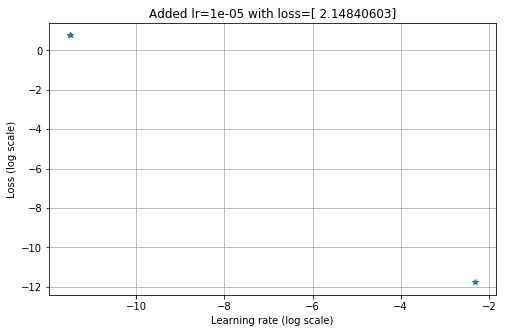

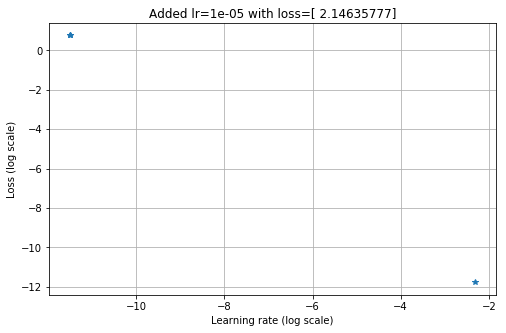

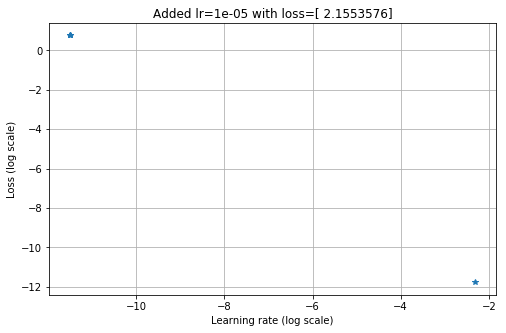

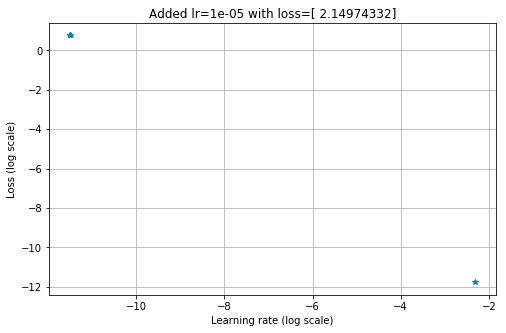

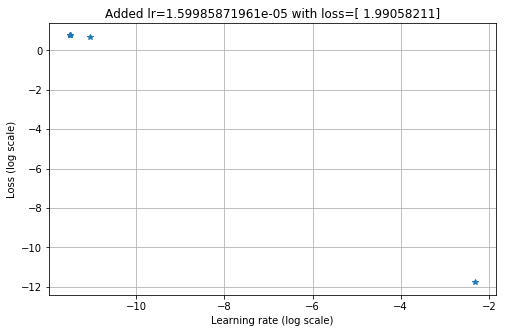

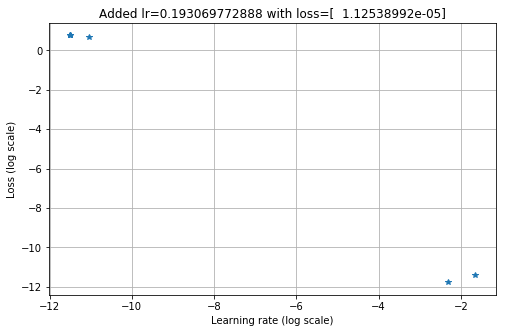

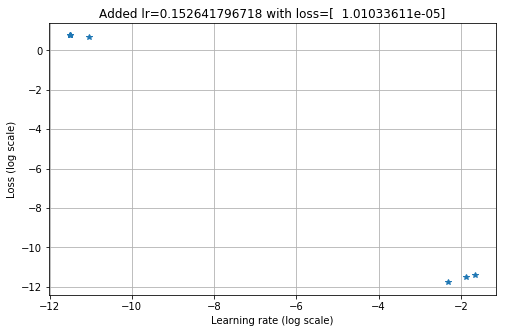

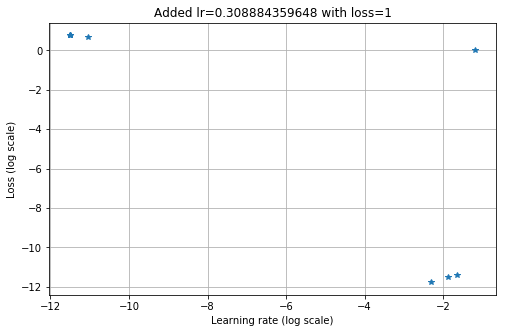

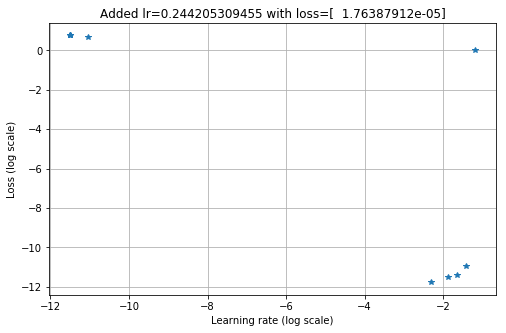

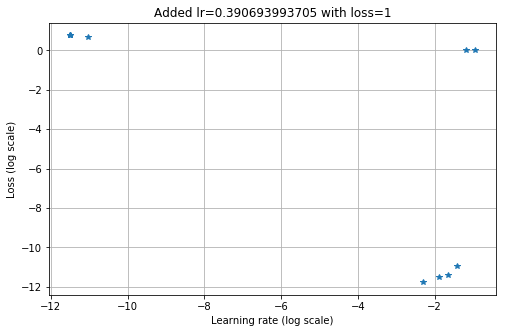

In [51]:
def acquisition(beta, mu, std):
    
    '''This acquisition function to evaluate the hyperparameter given the surrogate model'''
    
    return (-mu+beta*std)

#this is the search space for the hyperparameter to optimize
lr_range = np.logspace(-5,0) #values generated in log scale
beta = 2

#initial points
lr_list = [0.1, 0.00001]
lr_loss = []

for lr in lr_list:
    
    print("Trying ",lr)
    loss, loss_list = train_and_test(X_train, y_train, lr, train_step)
    lr_loss.append(loss[0])
    print("Loss:", loss[0])

#Sequential model based optimization
for i in range(10):

    print("Iteration",i)
    
    x_1 = np.array(lr_list).reshape(-1,1)
    y_1 = np.array(lr_loss).reshape(-1,1)

    gp.fit(x_1,y_1)

    print("Making the prediction")
    mu, std = gp.predict(lr_range.reshape(-1,1), return_std=True) 

    #adqusition evaluation of the hyperparameter
    a_lr = [acquisition(2, mu_i, std_i)[0] for mu_i, std_i in zip(mu,std)]
    new_lr = lr_range[np.argmin(a_lr)]
    loss, loss_list = train_and_test(X_train, y_train, new_lr, train_step)
    
    if(np.isnan(loss[0])):
        loss=1
        lr_loss.append(loss)
        lr_list.append(new_lr)
    else:
        lr_loss.append(loss[0])
        lr_list.append(new_lr)
    
    x_axis = np.log(lr_list)
    y_axis = np.log(lr_loss)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot( x_axis, y_axis , '*')
    ax.grid()
    ax.set_title("Added lr="+str(new_lr)+" with loss="+str(loss))
    ax.set_xlabel("Learning rate (log scale)")
    ax.set_ylabel("Loss (log scale)")
    

Text(0.5,1,'Values explored by the surrogate model')

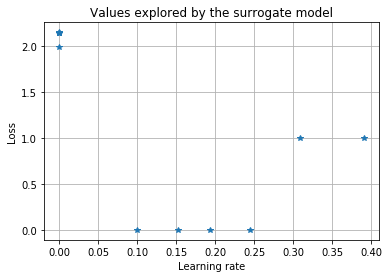

In [52]:
#plotting the loss vs. hyperaparameters
plt.plot(lr_list, lr_loss, '*')
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Values explored by the surrogate model")

In [53]:
best_lr= lr_list[np.argmin(lr_loss)]
print("Best learning rate:", best_lr)

Best learning rate: 0.1


In [54]:
#printing values learn by the surrogate model
pd.DataFrame({'Learning_rate': lr_list, 'Loss': lr_loss})

,Learning_rate,Loss
0,0.100000,0.000008
1,0.000010,2.150491
2,0.000010,2.148406
3,0.000010,2.146358
4,0.000010,2.155358
5,0.000010,2.149743
6,0.000016,1.990582
7,0.193070,0.000011
8,0.152642,0.000010
9,0.308884,1.000000


In [55]:
#predicting over test samples
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    y_pred = sess.run(output,  feed_dict={X: X_test, y:y_test})

Text(0,0.5,'Expected')

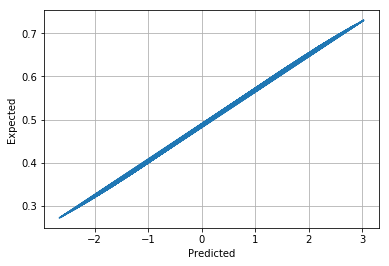

In [56]:
#plotting predicted vs. expected values of test set
plt.plot(y_pred, y_test)
plt.grid()
plt.xlabel("Predicted")
plt.ylabel("Expected")